In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [3]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-05-10 18:24:49,782 INFO: Initializing external client
2025-05-10 18:24:49,782 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-10 18:24:50,539 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1231000


In [4]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Error creating feature view: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1231000/featurestores/1214534/featureview). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270179,"usrMsg":"Feature view: time_series_hourly_feature_view_citi_bike, version: 1","errorMsg":"The provided feature view name and version already exists"}', error code: 270179, error msg: The provided feature view name and version already exists, user msg: Feature view: time_series_hourly_feature_view_citi_bike, version: 1
Feature view 'time_series_hourly_feature_view_citi_bike' (version 1) retrieved successfully.


In [5]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.90s) 


In [7]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [8]:
ts_data.head()

,pickup_hour,pickup_location_id,rides
0,2024-04-12 21:00:00+00:00,HB101,3
1,2024-04-12 22:00:00+00:00,HB101,2
2,2024-04-12 23:00:00+00:00,HB101,6
3,2024-04-13 00:00:00+00:00,HB101,1
4,2024-04-13 01:00:00+00:00,HB101,1


In [9]:
ts_data["pickup_hour"].min()

'2024-04-12 21:00:00+00:00'

In [10]:
ts_data["pickup_hour"].max()

'2025-05-10 18:00:00+00:00'

In [11]:
ts_data_copy = ts_data.copy()

In [12]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [13]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113627 entries, 0 to 113626
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype              
---  ------              --------------   -----              
 0   pickup_hour         113627 non-null  datetime64[ns, UTC]
 1   pickup_location_id  113627 non-null  object             
 2   rides               113627 non-null  int32              
dtypes: datetime64[ns, UTC](1), int32(1), object(1)
memory usage: 2.2+ MB


In [17]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None) 
print(f"Total records in input DataFrame: {len(ts_data)}")


Total records in input DataFrame: 113627


In [18]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113627 entries, 0 to 113626
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pickup_hour         113627 non-null  datetime64[ns]
 1   pickup_location_id  113627 non-null  object        
 2   rides               113627 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 2.2+ MB


In [19]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M") 

In [20]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2024-04-12 21:00:00,HB101,3,2024-04
1,2024-04-12 22:00:00,HB101,2,2024-04
2,2024-04-12 23:00:00,HB101,6,2024-04
3,2024-04-13 00:00:00,HB101,1,2024-04
4,2024-04-13 01:00:00,HB101,1,2024-04
...,...,...,...,...
113622,2025-05-10 14:00:00,JC116,0,2025-05
113623,2025-05-10 15:00:00,JC116,0,2025-05
113624,2025-05-10 16:00:00,JC116,0,2025-05
113625,2025-05-10 17:00:00,JC116,0,2025-05


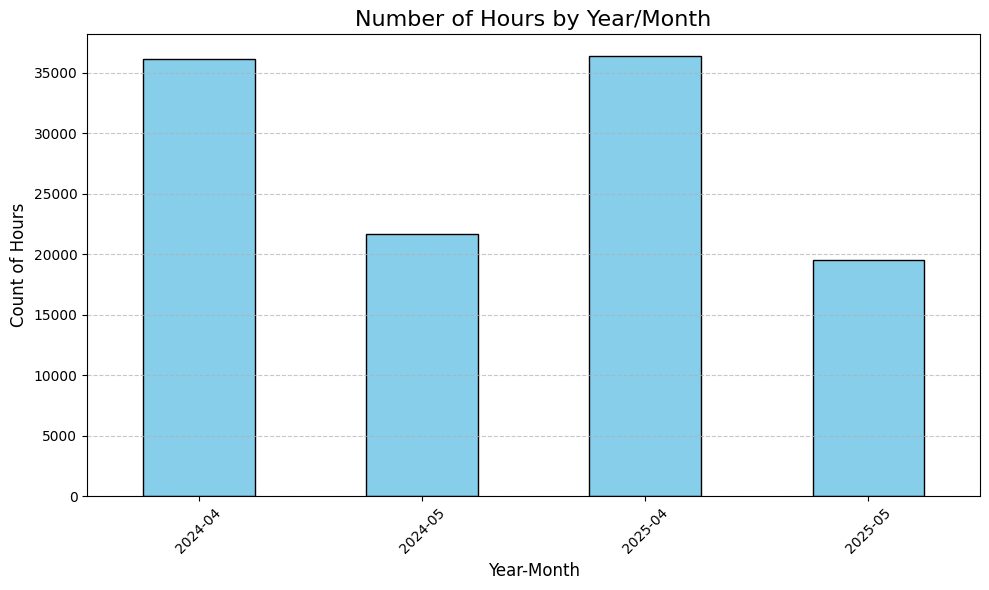

In [21]:
import matplotlib.pyplot as plt


hour_counts = ts_data.groupby("year_month").size()


ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  
plt.show()

In [22]:
ts_data.head()      

,pickup_hour,pickup_location_id,rides,year_month
0,2024-04-12 21:00:00,HB101,3,2024-04
1,2024-04-12 22:00:00,HB101,2,2024-04
2,2024-04-12 23:00:00,HB101,6,2024-04
3,2024-04-13 00:00:00,HB101,1,2024-04
4,2024-04-13 01:00:00,HB101,1,2024-04


In [ ]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")

gte = ts_data["year_month"] >= pd.Period("2023-12", freq="M")
lte = ts_data["year_month"] <= pd.Period("2025-12", freq="M")
cond = gte & lte

filtered_data = ts_data[cond].reset_index(drop=True)


In [33]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [34]:
filtered_data.shape

(113627, 3)

In [35]:
ts_data = filtered_data

In [36]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113627 entries, 0 to 113626
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pickup_hour         113627 non-null  datetime64[ns]
 1   pickup_location_id  113627 non-null  object        
 2   rides               113627 non-null  int32         
dtypes: datetime64[ns](1), int32(1), object(1)
memory usage: 2.2+ MB


In [37]:
ts_data.head()["pickup_hour"].values

array(['2024-04-12T21:00:00.000000000', '2024-04-12T22:00:00.000000000',
       '2024-04-12T23:00:00.000000000', '2024-04-13T00:00:00.000000000',
       '2024-04-13T01:00:00.000000000'], dtype='datetime64[ns]')

In [38]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)



In [39]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,3,2,6,1,1,0,0,0,0,0,...,1,7,5,7,7,5,6,1,2024-05-10 21:00:00,HB101
1,3,1,5,6,4,3,3,0,0,0,...,2,3,4,8,1,8,1,2,2024-05-11 20:00:00,HB101
2,5,11,1,0,1,0,0,0,0,0,...,0,0,0,0,23,0,0,0,2025-04-13 16:00:00,HB101
3,14,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,26,0,0,2025-04-14 15:00:00,HB101
4,12,6,3,3,1,1,1,0,0,0,...,18,0,0,0,0,0,41,0,2025-04-15 14:00:00,HB101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,2,1,2,0,2,0,0,0,0,0,...,0,0,0,0,46,0,0,0,2025-05-06 16:00:00,JC116
2569,6,8,0,0,1,1,0,0,0,0,...,0,0,0,0,0,41,0,0,2025-05-07 15:00:00,JC116
2570,15,13,3,1,2,0,2,0,0,0,...,11,0,0,0,0,0,43,0,2025-05-08 14:00:00,JC116
2571,3,5,7,4,0,0,0,3,2,2,...,0,4,0,0,0,0,0,20,2025-05-09 13:00:00,JC116


In [40]:
features[features["pickup_location_id"] == "HB101"]

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,3,2,6,1,1,0,0,0,0,0,...,1,7,5,7,7,5,6,1,2024-05-10 21:00:00,HB101
1,3,1,5,6,4,3,3,0,0,0,...,2,3,4,8,1,8,1,2,2024-05-11 20:00:00,HB101
2,5,11,1,0,1,0,0,0,0,0,...,0,0,0,0,23,0,0,0,2025-04-13 16:00:00,HB101
3,14,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,26,0,0,2025-04-14 15:00:00,HB101
4,12,6,3,3,1,1,1,0,0,0,...,18,0,0,0,0,0,41,0,2025-04-15 14:00:00,HB101
5,1,8,12,8,6,0,1,0,0,0,...,0,12,0,0,0,0,0,23,2025-04-16 13:00:00,HB101
6,3,9,12,12,5,1,0,0,0,0,...,0,0,1,0,0,0,0,0,2025-04-17 12:00:00,HB101
7,7,4,6,13,6,5,5,6,7,10,...,0,0,0,10,0,0,0,0,2025-04-18 11:00:00,HB101
8,4,4,6,7,10,9,5,10,11,5,...,0,0,0,0,2,0,0,0,2025-04-19 10:00:00,HB101
9,2,4,0,12,4,5,9,3,1,2,...,0,0,0,0,0,9,0,0,2025-04-20 09:00:00,HB101


In [41]:
features_copy = features.copy()

In [42]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(2573, 675)

In [43]:
from datetime import datetime, timedelta  
import pandas as pd  
from src.data_utils import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2025-04-12 18:30:40.763697')

In [44]:
features_targets


,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id,target
0,3,2,6,1,1,0,0,0,0,0,...,7,5,7,7,5,6,1,2024-05-10 21:00:00,HB101,2
1,3,1,5,6,4,3,3,0,0,0,...,3,4,8,1,8,1,2,2024-05-11 20:00:00,HB101,0
2,5,11,1,0,1,0,0,0,0,0,...,0,0,0,23,0,0,0,2025-04-13 16:00:00,HB101,0
3,14,2,2,0,0,0,0,0,0,0,...,0,0,0,0,26,0,0,2025-04-14 15:00:00,HB101,0
4,12,6,3,3,1,1,1,0,0,0,...,0,0,0,0,0,41,0,2025-04-15 14:00:00,HB101,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2568,2,1,2,0,2,0,0,0,0,0,...,0,0,0,46,0,0,0,2025-05-06 16:00:00,JC116,0
2569,6,8,0,0,1,1,0,0,0,0,...,0,0,0,0,41,0,0,2025-05-07 15:00:00,JC116,0
2570,15,13,3,1,2,0,2,0,0,0,...,0,0,0,0,0,43,0,2025-05-08 14:00:00,JC116,0
2571,3,5,7,4,0,0,0,3,2,2,...,4,0,0,0,0,0,20,2025-05-09 13:00:00,JC116,0


In [45]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(166, 674)
(166,)
(2407, 674)
(2407,)


In [46]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int64(672), object(1)
memory usage: 874.2+ KB


In [47]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [48]:
pipeline.fit(features, targets)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17396
[LightGBM] [Info] Number of data points in the train set: 2573, number of used features: 675
[LightGBM] [Info] Start training from score 1.542169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function average_rides_last_4_weeks at 0x311d641f0>)),
                ('temporalfeatureengineer', TemporalFeatureEngineer()),
                ('lgbmregressor', LGBMRegressor())])

In [49]:
from sklearn.metrics import mean_absolute_error
predictions = pipeline.predict(features)

In [50]:
predictions

array([ 1.99220520e+00,  2.36909466e-01, -2.67123208e-02, ...,
        1.11710756e-01,  8.63086817e-01,  5.40909168e+01])

In [51]:
test_mae = mean_absolute_error(targets, predictions)
print(f"{test_mae:.4f}")

0.1537


In [52]:
import joblib  


# Save the pipeline  
joblib.dump(pipeline, config.MODELS_DIR / "lgb_model.pkl")

['/Users/ajit/Desktop/Citibike_prediction_aml/models/lgb_model.pkl']

In [53]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [54]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
    #include_files=["src/", "requirements.txt"]  # Include directories and files
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
model.save(str(config.MODELS_DIR) + "/lgb_model.pkl")
# model.save('C:\\Users\\mkhaw\\github\\sp25_taxi\\models\\lgb_model.pkl')

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/ajit/Desktop/Citibike_prediction_aml/models/lgb_model.pkl: 0.000%|          | 0/321411 elapse…

Uploading /Users/ajit/Desktop/Citibike_prediction_aml/notebooks/input_example.json: 0.000%|          | 0/2098 …

Uploading /Users/ajit/Desktop/Citibike_prediction_aml/notebooks/model_schema.json: 0.000%|          | 0/48706 …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1231000/models/taxi_demand_predictor_next_hour/1


Model(name: 'taxi_demand_predictor_next_hour', version: 1)

In [55]:
model

Model(name: 'taxi_demand_predictor_next_hour', version: 1)

In [56]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

2025-05-10 18:34:21,788 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-05-10 18:34:21,790 INFO: Initializing external client
2025-05-10 18:34:21,791 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-05-10 18:34:22,541 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1231000


Downloading: 0.000%|          | 0/309419 elapsed<00:00 remaining<?

In [57]:
from src.inference import get_model_predictions

In [58]:
preds = get_model_predictions(model, features_copy)

In [59]:
preds

,pickup_location_id,predicted_demand
0,HB101,4.0
1,HB101,6.0
2,HB101,3.0
3,HB101,5.0
4,HB101,3.0
...,...,...
2568,JC116,1.0
2569,JC116,1.0
2570,JC116,3.0
2571,JC116,1.0


In [60]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")

1.8236
